In [1]:
# prerequisites
import numpy as np
import math as m
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Lambda, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from keras import objectives
from scipy.stats import norm

Using TensorFlow backend.


In [2]:
# data load
(x_tr, y_tr), (x_te, y_te) = mnist.load_data()
x_tr, x_te = x_tr.astype('float32')/255., x_te.astype('float32')/255.
x_tr, x_te = x_tr.reshape(x_tr.shape[0], -1), x_te.reshape(x_te.shape[0], -1)
print(x_tr.shape, x_te.shape)

# network parameters
batch_size, n_epoch = 100, 110
n_hidden, z_dim = 1024, 2

(60000, 784) (10000, 784)


In [3]:
# encoder
# Initializer imported from Cao code.  May do tuning here.
initializer = tf.keras.initializers.VarianceScaling(
scale=0.1, mode='fan_in', distribution='normal')

# Activation functions require elu followed by tanh.
x = Input(shape=(x_tr.shape[1:]))
x_encoded = Dense(n_hidden, activation='elu', kernel_initializer=initializer)(x)
x_encoded = Dropout(0.05)(x_encoded)
x_encoded = Dense(n_hidden//2, activation='elu', kernel_initializer=initializer)(x_encoded)
x_encoded = Dropout(0.05)(x_encoded)
x_encoded = Dense(n_hidden//4, activation='tanh', kernel_initializer=initializer)(x_encoded)
x_encoded = Dropout(0.05)(x_encoded)

mean_calc = Dense(z_dim, kernel_initializer=initializer)(x_encoded)

#### Rename log_var to log_stddev
log_stddev = Dense(z_dim, kernel_initializer=initializer)(x_encoded)

# Stddev initially is log.  It gets called as an exponential when being sampled.
stddev_calc = 0.000001 + (log_stddev)

In [4]:
# sampling function.  Function names have been cleaned up.
def sampling(args):
    mean_calc, stddev_calc = args
    eps = K.random_normal(shape=(batch_size, z_dim), mean=0., stddev=1.0)
    return mean_calc + K.exp(stddev_calc) * eps

z = Lambda(sampling, output_shape=(z_dim,))([mean_calc, stddev_calc])
#### Modify this part to sample from coupled gaussians instead of gaussians.

In [5]:
# decoder.  Following convention from Cao code, it has VarianceScaling, along with activation functions tanh,
# elu, and sigmoid.  Also imported dropout following convention.
initializer = tf.keras.initializers.VarianceScaling(
scale=0.1, mode='fan_in', distribution='normal')

z_decoder0 = Dense(n_hidden//4, activation='tanh', kernel_initializer=initializer)
z_decoder1 = Dense(n_hidden//2, activation='elu', kernel_initializer=initializer)
z_decoder2 = Dense(n_hidden, activation='elu', kernel_initializer=initializer)
y_decoder = Dense(x_tr.shape[1], activation='sigmoid', kernel_initializer=initializer)

z_decoded = z_decoder0(z)
z_decoded = Dropout(0.05)(z_decoded)
z_decoded = z_decoder1(z_decoded)
z_decoded = Dropout(0.05)(z_decoded)
z_decoded = z_decoder2(z_decoded)
z_decoded = Dropout(0.05)(z_decoded)
y = y_decoder(z_decoded)
y = tf.clip_by_value(y, 1e-8, 1 - 1e-8)

In [18]:
#### Latent loss and image loss for Coupled VAE.
k = 0.1
d = 20
d1 = 1 + d * k + 2 * k
marginal_likelihood = tf.reduce_sum(x * tf.subtract(tf.pow(y, (2 * k) / (1 + k)), 1) / (2 * k) + (1 - x)
                                    * tf.subtract(tf.pow(1 - y, (2 * k) / (1 + k)), 1) / (k * 2), 1)
KL_d1 = tf.reduce_prod(tf.pow(2 * tf.constant(m.pi), k / (1 + d * k)) * tf.sqrt(d1 / (d1 - 2 * k * tf.square(stddev_calc)))
                       * tf.exp(tf.square(mean_calc) * d1 * k / (1 + d * k) / (d1 - 2 * k * tf.square(stddev_calc))), 1)
KL_d2 = tf.reduce_prod(tf.pow(2 * tf.constant(m.pi) * tf.square(stddev_calc),
                              k / (1 + k * d)) * tf.sqrt(d1 / (1 + d * k)), 1)
KL_divergence = (KL_d1 - KL_d2) / k / 2
ml = marginal_likelihood
marginal_likelihood = tf.reduce_mean(marginal_likelihood)

In [19]:
# loss
#reconstruction_loss = objectives.binary_crossentropy(x, y) * x_tr.shape[1]
#kl_loss = 0.5 * K.sum(K.square(mu) + K.exp(log_var) - log_var - 1, axis = -1)
ELBO = marginal_likelihood - KL_divergence
vae_loss = -ELBO

#vae_loss = reconstruction_loss + kl_loss

# build model
vae = Model(x, y)
vae.add_loss(vae_loss)
opt = keras.optimizers.Adam(learning_rate=1e-3)
vae.compile(optimizer=opt)
vae.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 1024)         803840      input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 1024)         0           dense[0][0]                      
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 512)          524800      dropout[0][0]                    
____________________________________________________________________________________________

In [20]:
# train
vae.fit(x_tr,
       shuffle=True,
       epochs=n_epoch,
       batch_size=batch_size,
       validation_data=(x_te, None), verbose=1)

Epoch 1/110
600/600 [==============================] - 30s 50ms/step - loss: 116.9536 - val_loss: 114.4820
Epoch 2/110
600/600 [==============================] - 30s 49ms/step - loss: 116.7485 - val_loss: 114.1349
Epoch 3/110
600/600 [==============================] - 28s 47ms/step - loss: 116.7821 - val_loss: 114.2461
Epoch 4/110
600/600 [==============================] - 28s 47ms/step - loss: 116.7977 - val_loss: 114.6589
Epoch 5/110
600/600 [==============================] - 184s 307ms/step - loss: 116.8055 - val_loss: 114.6925
Epoch 6/110
600/600 [==============================] - 27s 46ms/step - loss: 116.8886 - val_loss: 114.7859
Epoch 7/110
600/600 [==============================] - 114s 190ms/step - loss: 116.8273 - val_loss: 114.6426
Epoch 8/110
600/600 [==============================] - 145s 242ms/step - loss: 117.1767 - val_loss: 115.0418
Epoch 9/110
600/600 [==============================] - 167s 278ms/step - loss: 116.8528 - val_loss: 114.5793
Epoch 10/110
600/600 [=======

600/600 [==============================] - 16s 27ms/step - loss: 116.8827 - val_loss: 114.5425
Epoch 77/110
600/600 [==============================] - 16s 27ms/step - loss: 116.6402 - val_loss: 114.5496
Epoch 78/110
600/600 [==============================] - 16s 27ms/step - loss: 116.7974 - val_loss: 114.7936
Epoch 79/110
600/600 [==============================] - 16s 27ms/step - loss: 116.9163 - val_loss: 114.2345
Epoch 80/110
600/600 [==============================] - 15s 25ms/step - loss: 116.7601 - val_loss: 114.2756
Epoch 81/110
600/600 [==============================] - 15s 25ms/step - loss: 116.6387 - val_loss: 114.5575
Epoch 82/110
600/600 [==============================] - 15s 25ms/step - loss: 116.6533 - val_loss: 114.3856
Epoch 83/110
600/600 [==============================] - 16s 27ms/step - loss: 116.7935 - val_loss: 115.0449
Epoch 84/110
600/600 [==============================] - 15s 25ms/step - loss: 116.5547 - val_loss: 114.0081
Epoch 85/110
600/600 [===================

In [21]:
# build encoder
encoder = Model(x, mean_calc)
encoder.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              803840    
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0   

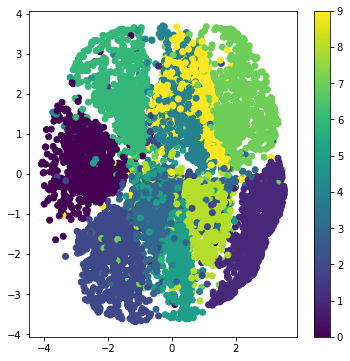

In [22]:
# Plot of the digit classes in the latent space
x_te_latent = encoder.predict(x_te, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_te_latent[:, 0], x_te_latent[:, 1], c=y_te)
plt.colorbar()
plt.show()

In [23]:
# build decoder
decoder_input = Input(shape=(z_dim,))
_z_decoded = z_decoder0(decoder_input)
_z_decoded = z_decoder1(_z_decoded)
_z_decoded = z_decoder2(_z_decoded)
_y = y_decoder(_z_decoded)
generator = Model(decoder_input, _y)
generator.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_5 (Dense)              multiple                  768       
_________________________________________________________________
dense_6 (Dense)              multiple                  131584    
_________________________________________________________________
dense_7 (Dense)              multiple                  525312    
_________________________________________________________________
dense_8 (Dense)              multiple                  803600    
Total params: 1,461,264
Trainable params: 1,461,264
Non-trainable params: 0
_________________________________________________________________


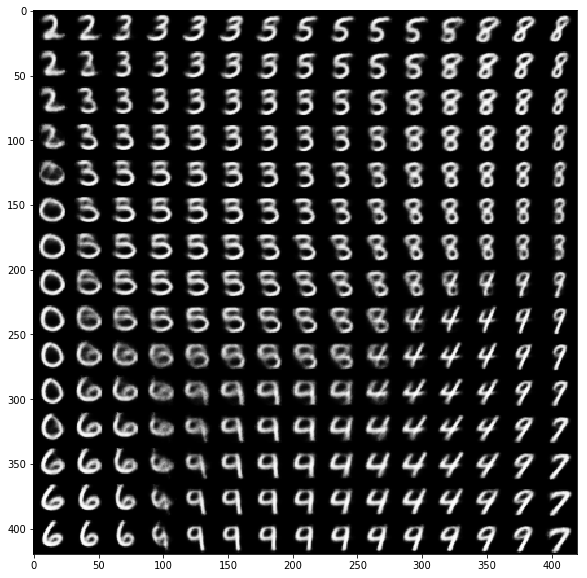

In [24]:
# display a 2D manifold of the digits
n = 15 # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

grid_x = norm.ppf(np.linspace(0.05, 0.95, n)) 
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()